# Hierarchical Dispatch

This notebook illustrates an example of how to use Osier's `LogicDispatchModel`.

In [1]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unyt import MW, GW, km, unyt_array

# osier imports
from osier import LogicDispatchModel, DispatchModel
from osier.tech_library import nuclear_adv, wind, battery, natural_gas
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

In [2]:
N=24
demand = np.ones(N)*100
wind_speed = np.random.weibull(a=2.5,size=N)

In [3]:
battery.storage_capacity

unyt_quantity(3261.36504, 'MW*hr')

In [4]:
nuclear_adv.capacity = 50
wind.capacity = 100
battery.capacity = 100

natural_gas.capacity = 0.1

In [5]:
nuclear_adv.reset_history()

In [6]:
nuclear_adv.power_level

unyt_quantity(50., 'MW')

In [7]:
nuclear_adv.power_output(demand=-1*MW)

unyt_quantity(37.5, 'MW')

In [8]:
battery.initial_storage = 100

In [9]:
natural_gas.power_output(-100*MW)

unyt_quantity(0., 'MW')

In [10]:
battery.storage_level

unyt_quantity(100, 'MWh')

In [11]:
natural_gas.power_output(-0.01*MW)

unyt_quantity(0., 'MW')

In [12]:
nuclear_adv.power_output(-1*MW)

unyt_quantity(25., 'MW')

In [13]:
battery.power_output(-1000*MW)

unyt_quantity(-100., 'MW')

In [14]:
battery.charge(100*MW)

unyt_quantity(0., 'MW')

In [15]:
battery.storage_level

unyt_quantity(200., 'MWh')

In [16]:
battery.storage_level

unyt_quantity(200., 'MWh')

In [17]:
natural_gas.power_output(-1*MW)

unyt_quantity(0., 'MW')

In [18]:
tech_list = [nuclear_adv, wind, battery, natural_gas]
tech_list

[Nuclear_Adv: 50.0 MW,
 WindTurbine: 100.0 MW,
 Battery: 100.0 MW,
 NaturalGas_Conv: 0.1 MW]

In [19]:
net_demand = demand - wind_speed*wind.capacity.to_value()
net_demand

array([ 53.39487091, -40.10054983,  53.97860494,  27.01922515,
        50.32396895,  67.59012572,  20.03792269,  76.55838803,
         3.3748523 ,  39.97291007,  42.51004457,   8.88657628,
       -19.57365318,   3.92774161, -48.46142547, -69.76925155,
       -37.01867128, -52.49792234,  25.3980917 ,  -3.77512012,
       -18.30934924,  -1.23386905,  17.45592987,  11.18576393])

In [33]:
model = LogicDispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand)

In [34]:
covered_dem = model.solve()

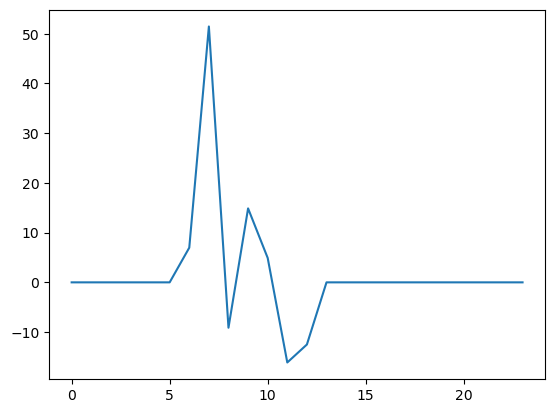

In [35]:
plt.plot(model.covered_demand)

In [36]:
data = {}
for t in model.technology_list:
    if t.technology_type == 'storage':
        if len(t.power_history) == 0:
            data[f"{t.technology_name}_charge"] = np.zeros(len(model.net_demand))
        else:
            data[f"{t.technology_name}_charge"] = unyt_array(t.power_history).to_ndarray()
        if len(t.storage_history) == 0:
            data[f"{t.technology_name}_level"] = np.zeros(len(model.net_demand))
        else:
            data[f"{t.technology_name}_level"] = unyt_array(t.storage_history).to_ndarray()
    else:
        if len(t.power_history) == 0:
            data[t.technology_name] = np.zeros(len(model.net_demand))
        else:
            data[t.technology_name] = unyt_array(t.power_history).to_ndarray()
# results = pd.DataFrame(data)

In [37]:
for k,v in data.items():
    print(k)
    print(len(v))

Battery_charge
244
Battery_level
244
Nuclear_Adv
242
NaturalGas_Conv
243


In [30]:
print(battery.storage_level)
v = -10*MW
v -= battery.charge(v)
print(v)
print(battery.storage_level)

202.67173512710994 MWh
0.0 MW
212.67173512710994 MWh


In [31]:
battery.power_history

[unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(53.39487091, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(53.97860494, 'MW'),
 unyt_quantity(27.01922515, 'MW'),
 unyt_quantity(50.32396895, 'MW'),
 unyt_quantity(55.38387989, 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0., 'MWh/hr'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(3.92774161, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(25.3980917, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(17.45592987, 'MW'),
 unyt_quantity(11.18576393, 'MW'),
 unyt_quantity(53.39487091, 'MW'),
 unyt_quantity(0, 'MW'),
 unyt_quantity(53.97860494, 'MW'),
 unyt_quantity(27.01922515, 'MW'),
 unyt_quantity(50.32396895, 'MW'),
 unyt_quantity(48.05561502, 'MWh/hr'),
 unyt_quantity(0., 'MWh/

In [32]:
for k,v in data.items():
    print(k)
    print(len(v))

Battery_charge
218
Battery_level
218
Nuclear_Adv
218
NaturalGas_Conv
219


In [ ]:
data

{'Nuclear_Adv': array([37.5       , 50.        , 37.5       , 50.        , 37.5       ,
        49.78414396, 37.28414396, 24.78414396, 37.28414396, 24.78414396,
        12.28414396, 24.78414396, 12.28414396, 16.77937897, 29.27937897,
        41.77937897, 50.        , 39.00609873, 43.10780205, 30.60780205,
        27.73601117, 40.23601117, 27.73601117, 15.23601117]),
 'Battery_charge': array([ -82.1813007 ,    2.07971782,   -5.15921155,   27.00837748,
         -28.39410668,  -14.16870904,   -7.16737048,   17.09172966,
         -29.4173956 , -100.        ,    2.42830196,  -15.82984773,
          51.30356091,    2.3279931 ,    0.39961634,   -1.34367829,
          19.00898264,  -64.94981954,   -9.29882982]),
 'Battery_level': array([182.1813007 , 180.10158287, 185.26079442, 158.25241694,
        186.64652361, 200.81523266, 207.98260313, 190.89087347,
        220.30826907, 320.30826907, 317.87996711, 333.70981484,
        282.40625393, 280.07826083, 279.67864449, 281.02232278,
        262.0

In [ ]:
net_demand

array([-44.6813007 ,  52.17971782,  32.34078845,  77.10837748,
         9.10589332,  49.78414396,  23.11543492,  17.61677349,
        54.47587362,  -4.63325164, -98.06333831,  27.31244593,
        -3.54570377,  16.77937897,  80.68293988,  44.20737206,
        50.49961634,  39.00609873,  43.10780205,  29.26412377,
        27.73601117,  59.34499381, -37.21380837,   5.93718136])

In [ ]:
battery.power_level

unyt_quantity(0., 'MW')

In [ ]:
pd.DataFrame(data)

ValueError: All arrays must be of the same length

In [ ]:
ax = results.plot.area(linewidth=0)
ax.plot(model.net_demand, lw=3, label='Demand')
ax.legend()

NameError: name 'results' is not defined

In [ ]:
original_model = DispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand)

In [ ]:
%%timeit
original_model.solve()

80.6 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<Axes: >

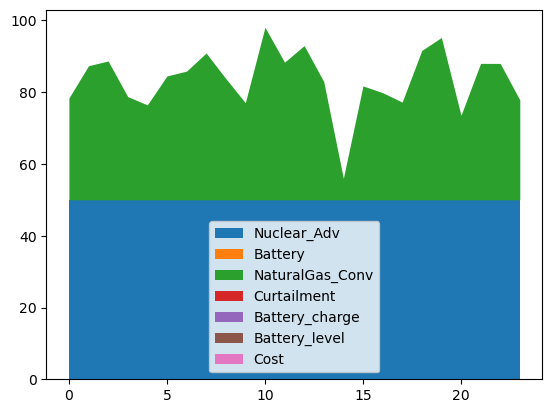

In [ ]:
original_model.results.plot.area(lw=0)

In [ ]:
from timeit import timeit, repeat

In [ ]:
logic_time = timeit(stmt="model.solve()",
                    globals=globals(),
                    number=7)

In [ ]:
logic_time = repeat(stmt="model.solve()",
                    globals=globals(),
                    repeat=7,
                    number=10)

In [ ]:
(np.array(logic_time)/10*1e3).std()

np.float64(3.4105235536040897)